# Lotka–Volterra ODE Model (pretty much taken from NumPyro)



**Model equations:**
- $\frac{du}{dt} = (\alpha - \beta v) \cdot u$ (prey dynamics)
- $\frac{dv}{dt} = (-\gamma + \delta u) \cdot v$ (predator dynamics)




In [11]:
# Uncomment if you don't have the packages installed

# using Pkg
# Pkg.add(["Gen", "DifferentialEquations", "Distributions"])

In [12]:
# Load required packages
using Gen
using DifferentialEquations
using Distributions
using Random
using Statistics

## Lotka-Volterra Differential Equation

In [13]:

function lotka_volterra_ode!(dz, z, theta, t)
    u, v = z              
    α, β, γ, δ = theta    
    
    dz[1] = (α - β * v) * u      
    dz[2] = (-γ + δ * u) * v     
end

lotka_volterra_ode! (generic function with 1 method)

##  ODE (Ordinary Differential EquaTion) solver



In [14]:

function solve_lv(theta, z_init, ts)
    tspan = (minimum(ts), maximum(ts))
    
    # solve the ODE using some solver
    prob = ODEProblem(lotka_volterra_ode!, z_init, tspan, theta)
    sol = solve(prob, Tsit5(), saveat=ts, abstol=1e-8, reltol=1e-8)

    # Convert solution to T×2 array, where T - time steps and we have 1 T array for each species
    T = length(ts)
    z_true = zeros(T, 2)
    for i in 1:T
        z_true[i, 1] = sol.u[i][1]  # prey
        z_true[i, 2] = sol.u[i][2]  # predator
    end
    
    return z_true
end

solve_lv (generic function with 1 method)

## Model

In [15]:

@gen function lv_model(ts)
    # Positive parameters via log-parameterization 
    α_log = {:alpha_log} ~ Gen.normal(log(1.0), 0.5)
    β_log = {:beta_log}  ~ Gen.normal(log(0.05), 0.5)
    γ_log = {:gamma_log} ~ Gen.normal(log(1.0), 0.5)
    δ_log = {:delta_log} ~ Gen.normal(log(0.05), 0.5)

    α = exp(α_log)
    β = exp(β_log)
    γ = exp(γ_log)
    δ = exp(δ_log)

    theta = (α, β, γ, δ)

    # Sample initial conditions from priors
    z_init_1_log = {(:z_init, 1)} ~ Gen.normal(log(10.0), 1.0)
    z_init_2_log = {(:z_init, 2)} ~ Gen.normal(log(10.0), 1.0)
    z_init = [exp(z_init_1_log), exp(z_init_2_log)]

    # Sample observation noise (LogNormal prior)
    sigma_obs_log = {:sigma_obs} ~ Gen.normal(-1.0, 1.0)
    sigma_obs = exp(sigma_obs_log)
    
    # Solve the ODE using the solver 
    z_true = solve_lv(theta, z_init, ts)
    
    # Generate observations with lognormal noise
    T = length(ts)
    y_obs = zeros(T, 2)
    
    for t in 1:T
        for i in 1:2
            # the log(0) case screws everything up, so handle it
            z_clamped = max(z_true[t, i], 1e-9)
            # observation y ~ LogNormal(log(z_true), sigma_obs)
            y_log = {(:y, t, i)} ~ Gen.normal(log(z_clamped), sigma_obs)
            y_obs[t, i] = exp(y_log)
        end
    end
    
    # Return all relevant quantities
    # print(z_true = z_true,
    #     y_obs = y_obs,
    #     theta = theta,
    #     z_init = z_init,
    #     sigma_obs = sigma_obs)
    return (
        z_true = z_true,
        y_obs = y_obs,
        theta = theta,
        z_init = z_init,
        sigma_obs = sigma_obs
    )
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], Main.var"##lv_model#282", Bool[0], false)

## Simulation


In [16]:

function simulate_data(ts; seed=42)
    Random.seed!(seed)
    
    trace = Gen.simulate(lv_model, (ts,))
    
    retval = Gen.get_retval(trace)
    
    return (
        trace = trace,
        y_obs = retval.y_obs,
        true_theta = retval.theta,
        true_z_init = retval.z_init,
        true_sigma_obs = retval.sigma_obs,
        z_true = retval.z_true
    )
end

simulate_data (generic function with 1 method)

In [17]:
# Generate 81 obs with a 0.5 time step
ts = collect(0.0:0.5:40.0)  

sim_result = simulate_data(ts, seed=123)

println("True parameters used for simulation:")
println("  α = $(round(sim_result.true_theta[1], digits=4))")
println("  β = $(round(sim_result.true_theta[2], digits=4))")
println("  γ = $(round(sim_result.true_theta[3], digits=4))")
println("  δ = $(round(sim_result.true_theta[4], digits=4))")
println("\nTrue initial conditions:")
println("  u₀ = $(round(sim_result.true_z_init[1], digits=4))")
println("  v₀ = $(round(sim_result.true_z_init[2], digits=4))")
println("\nTrue observation noise:")
println("  σ_obs = $(round(sim_result.true_sigma_obs, digits=4))")
println("\nNumber of observations: $(length(ts))")

True parameters used for simulation:
  α = 0.7241
  β = 0.0241
  γ = 0.4441
  δ = 0.0448

True initial conditions:
  u₀ = 16.3599
  v₀ = 26.6707

True observation noise:
  σ_obs = 0.3985

Number of observations: 81


## Visualisation



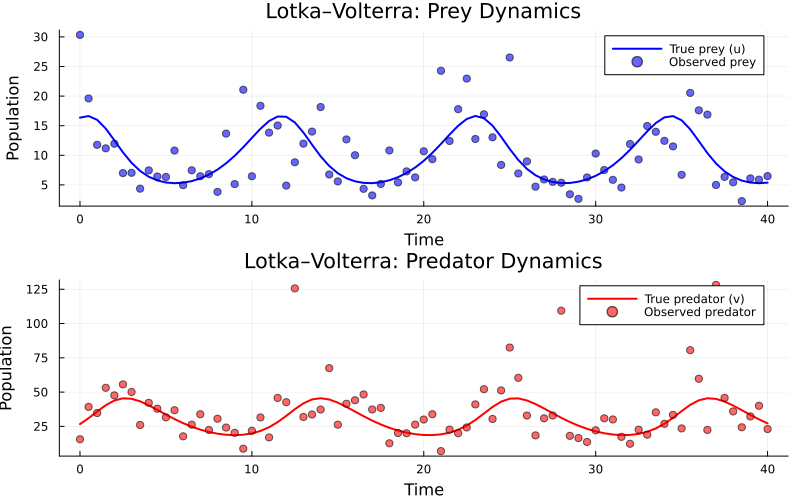

In [18]:
using Plots

# Plot the true trajectory and noisy observations
p1 = plot(ts, sim_result.z_true[:, 1], 
    label="True prey (u)", 
    linewidth=2, 
    color=:blue,
    xlabel="Time",
    ylabel="Population",
    title="Lotka–Volterra: Prey Dynamics")
scatter!(p1, ts, sim_result.y_obs[:, 1], 
    label="Observed prey", 
    color=:blue, 
    alpha=0.6,
    markersize=4)

p2 = plot(ts, sim_result.z_true[:, 2], 
    label="True predator (v)", 
    linewidth=2, 
    color=:red,
    xlabel="Time",
    ylabel="Population",
    title="Lotka–Volterra: Predator Dynamics")
scatter!(p2, ts, sim_result.y_obs[:, 2], 
    label="Observed predator", 
    color=:red, 
    alpha=0.6,
    markersize=4)

plot(p1, p2, layout=(2, 1), size=(800, 500), legend=:topright)


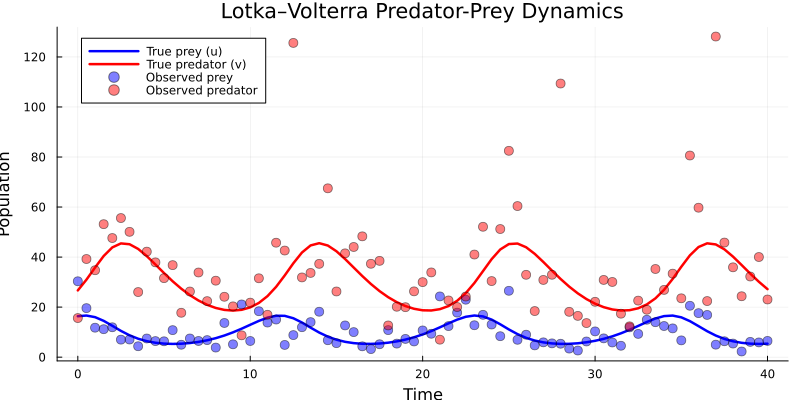

In [19]:
# Combined plot: both species together
plot(ts, sim_result.z_true[:, 1], 
    label="True prey (u)", 
    linewidth=2.5, 
    color=:blue,
    xlabel="Time",
    ylabel="Population",
    title="Lotka–Volterra Predator-Prey Dynamics",
    size=(800, 400))
plot!(ts, sim_result.z_true[:, 2], 
    label="True predator (v)", 
    linewidth=2.5, 
    color=:red)
scatter!(ts, sim_result.y_obs[:, 1], 
    label="Observed prey", 
    color=:blue, 
    alpha=0.5,
    markersize=5)
scatter!(ts, sim_result.y_obs[:, 2], 
    label="Observed predator", 
    color=:red, 
    alpha=0.5,
    markersize=5)